In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import scipy.stats  as stats
import seaborn as sns
import glob
import matplotlib.pyplot as plt
from quality.analyze_types import create_typed_predictions, get_entity_node_degrees, create_combined_df, create_combined_over_embeddings, _get_files, average_node_degree

In [3]:
embedding_approaches = ["BootEA","MultiKE","RDGCN"]
dataset_name = "EN_DE_15K_V1"
type_files = sorted([i for i in glob.iglob(f"/home/dobraczka/Downloads/git/er-embedding-benchmark/data/OpenEA/typed_links/datasets/{dataset_name}/721_5fold/*/typed_test")])

In [4]:
combined = create_combined_over_embeddings(embedding_approaches, dataset_name, type_files,"/home/dobraczka/Downloads/git/er-embedding-benchmark/data/")

Create combined df: 100%|██████████| 3/3 [00:10<00:00,  3.59s/it]


In [6]:
g = sns.scatterplot(x="Type",y="fn rate",hue="Embedding approach",style="Embedding approach",data=combined)
for label in g.get_xticklabels():
    label.set_rotation(90)

AttributeError: 'tuple' object has no attribute 'get'

In [ ]:
def stylize(df):
    cm = sns.cubehelix_palette(5, as_cmap=True)
    return df.style.background_gradient(cmap=cm, axis=1)

In [ ]:
bootea = combined[combined["Embedding approach"]=="BootEA"]
rdgcn = combined[combined["Embedding approach"]=="RDGCN"]
multike = combined[combined["Embedding approach"]=="MultiKE"]

In [ ]:
stats.pearsonr(bootea[bootea["fn rate"].notna()]["fn rate"], bootea[bootea["fn rate"].notna()]["rate of all"])

In [ ]:
stats.kendalltau(combined[combined["fn rate"].notna()]["fn rate"], combined[combined["fn rate"].notna()]["rate of all"])

In [ ]:
g = sns.scatterplot(x="occurence",y="fn", hue="Embedding approach", style="Embedding approach", data=combined)
for label in g.get_xticklabels():
    label.set_rotation(90)

In [ ]:
#corr = combined[["occurence","fn","fp","avg node degree"]].corr(method="spearman")
#mask = np.zeros_like(corr)
#mask[np.triu_indices_from(mask)] = True
#with sns.axes_style("white"):
#    sns.heatmap(corr, mask=mask, square=True, annot=True)
sns.heatmap(combined[["fp rate","fn rate","avg node degree","rate of all"]].corr(method="spearman"), annot=True)

In [7]:
kg1_ent_id_files, kg2_ent_id_files, pred_files = _get_files(embedding_approaches[2], dataset_name, "/home/dobraczka/Downloads/git/er-embedding-benchmark/data/")
df = create_typed_predictions(
            kg1_ent_id_files,
            kg2_ent_id_files,
            pred_files,
            type_files,
            "/home/dobraczka/Downloads/git/er-embedding-benchmark/data/OpenEA/typed_links/superclasses.json",
            1,
            False,
        )
entity_degrees = get_entity_node_degrees(f"/home/dobraczka/Downloads/git/er-embedding-benchmark/data/OpenEA/{dataset_name}")

In [ ]:
ed = pd.Series(entity_degrees).to_frame(name="node degree")
ed.reset_index(inplace=True)
ed_left = ed.rename(columns={"index": "left_uri"})
ed_right = ed.rename(columns={"index": "right_uri"})
left = ed_left.merge(df, on="left_uri")[["left_uri","node degree"]]
right = ed_right.merge(df, on="right_uri")[["right_uri","node degree"]]
left = left.drop_duplicates()
right = right.drop_duplicates()
left = left.rename(columns={"node degree": "left node degree"})
right = right.rename(columns={"node degree": "right node degree"})
df_nd = df.merge(left, on="left_uri").merge(right, on="right_uri")
df_nd.loc[(df_nd["pred"] == 0) & (df_nd["val"] == 1), "match_type"] = "False\nNegative"
df_nd.loc[(df_nd["pred"] == 1) & (df_nd["val"] == 0), "match_type"] = "False\nPositive"
df_nd.loc[(df_nd["pred"] == 1) & (df_nd["val"] == 1), "match_type"] = "True\nPositive"
df_nd.loc[(df_nd["pred"] == 0) & (df_nd["val"] == 0), "match_type"] = "True\nNegative"
df_nd = df_nd.rename(columns={"left node degree": "EN","right node degree":"DE"})
melted = df_nd.melt(id_vars=["left_uri","right_uri","left_types","right_types","match_type"], value_vars=["EN","DE"], var_name="node degree", value_name="degree")
melted = melted.rename(columns={"left node degree": "EN","right node degree":"DE"})

In [30]:
dfs = []
for e in embedding_approaches:
    kg1_ent_id_files, kg2_ent_id_files, pred_files = _get_files(e, dataset_name, "/home/dobraczka/Downloads/git/er-embedding-benchmark/data/")
    df = create_typed_predictions(
            kg1_ent_id_files,
            kg2_ent_id_files,
            pred_files,
            type_files,
            "/home/dobraczka/Downloads/git/er-embedding-benchmark/data/OpenEA/typed_links/superclasses.json",
            1,
            False,
        )
    dfs.append(df)

In [36]:
average_node_degree(dfs[0],entity_degrees)

,node degree
Type,
http://dbpedia.org/ontology/Activity,3.000000
http://dbpedia.org/ontology/Agent,21.687500
http://dbpedia.org/ontology/AnatomicalStructure,31.000000
http://dbpedia.org/ontology/Cartoon,5.250000
http://dbpedia.org/ontology/Device,29.045455
http://dbpedia.org/ontology/Event,12.057692
http://dbpedia.org/ontology/Film,7.365365
http://dbpedia.org/ontology/Language,9.689655
http://dbpedia.org/ontology/Location,14.142370


In [ ]:
with sns.axes_style("darkgrid",{"ytick.left":True}):
    
    g = sns.stripplot(x="match_type",y="degree",hue="node degree",dodge=True,jitter=0.35,size=2,data=melted)
    g.set_yscale("log")
    plt.set
    print(sns.axes_style())

In [ ]:
sns.boxenplot(x="match_type",y="degree",hue="node degree",data=melted)

In [10]:
def set_errors(df, pred, val):
    if (df["pred"] == pred) & (df["val"] == val):
        return 1
    else:
        return 0

In [11]:
def calc_measures(data):
    df = data.copy()
    df["fn"] = df.apply(set_errors, args=(0,1), axis=1)
    df["fp"] = df.apply(set_errors, args=(1,0), axis=1)
    df["tp"] = df.apply(set_errors, args=(1,1), axis=1)
    df["tn"] = df.apply(set_errors, args=(0,0), axis=1)
    summed = (df.groupby("left_types").sum() + df.groupby("right_types").sum()) / 2
    summed["prec"] = summed["tp"] / (summed["tp"]+summed["fp"])
    summed["rec"] = summed["tp"] / (summed["tp"]+summed["fn"])
    summed["fm"] = 2*(summed["prec"]*summed["rec"]/(summed["prec"]+summed["rec"]))
    return summed[["prec","rec","fm"]]

In [ ]:
measured_df_bootea = calc_measures(df)

In [ ]:
measured_df_multike = calc_measures(df)

In [ ]:
measured_df_rdgcn = calc_measures(df)

In [12]:
measured = []
for d in dfs:
    measured.append(calc_measures(d))

In [13]:
#A.columns = pd.MultiIndex.from_product([["BootEA"], measured_df_bootea.columns])
#B.columns = pd.MultiIndex.from_product([['MultiKE'], measured_df_multike.columns])
#C.columns = pd.MultiIndex.from_product([['RDGCN'], measured_df_rdgcn.columns])

mult = pd.concat(measured, axis = 1, keys=(["BootEA","MultiKE","RDGCN"]))

In [31]:
final = mult.sort_index(axis=1, level=1).swaplevel(axis=1)

In [32]:
final = final.reset_index().rename(columns={"left_types":"Type"})
#final["Type"] = [x.split("/")[-1].split("#")[-1] for x in final["Type"].astype(str)]
final = final.set_index("Type").drop("index",level=0,axis=1)

In [ ]:
final.fillna(-1).style.background_gradient(cmap='Greens',axis=1)

In [44]:
melted = final["fm"].reset_index().melt(id_vars=["Type"],value_vars=["BootEA","MultiKE","RDGCN"], var_name="Approach",value_name="F-measure")
melted = melted.set_index("Type")

In [49]:
nds = melted.join(average_node_degree(dfs[0],entity_degrees))
nds.reset_index(inplace=True)
nds[nds["Approach"]=="BootEA"]

,Type,Approach,F-measure,node degree
0,http://dbpedia.org/ontology/Activity,BootEA,NaN,3.000000
3,http://dbpedia.org/ontology/Agent,BootEA,NaN,21.687500
6,http://dbpedia.org/ontology/AnatomicalStructure,BootEA,0.500000,31.000000
9,http://dbpedia.org/ontology/Cartoon,BootEA,0.933333,5.250000
12,http://dbpedia.org/ontology/Device,BootEA,0.877698,29.045455
15,http://dbpedia.org/ontology/Event,BootEA,0.351852,12.057692
18,http://dbpedia.org/ontology/Film,BootEA,0.866589,7.365365
21,http://dbpedia.org/ontology/Language,BootEA,0.840580,9.689655
24,http://dbpedia.org/ontology/Location,BootEA,0.785478,14.142370
27,http://dbpedia.org/ontology/MeanOfTransportation,BootEA,0.590444,11.864407


<AxesSubplot:xlabel='node degree', ylabel='F-measure'>

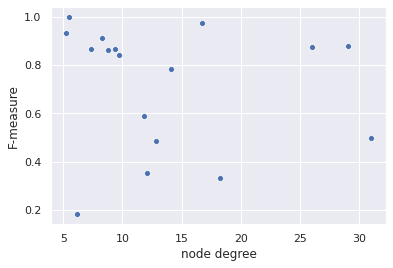

In [51]:
sns.scatterplot(x="node degree",y="F-measure",data=nds[nds["Approach"]=="BootEA"])